# Magnetic Data processing

In this notebook you will undertake the data processing steps that are necessary in order to produce a magnetic anomaly map

## Importing external libraries

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from pathlib import Path
from scipy import interpolate
import pyproj

## Importing and visualizing data

The next cells will load the data. 
You will need change the file-path as well as your student id

In [12]:
# Enter the path to your data folder here
filename = Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Raw') 
student_id = ""

# Reading the dataset
data = pd.read_csv(os.path.join(filename, "mag_data_"+str(student_id)+".csv"))

# Renaming some columns for easier coding later on 
data = data.rename(columns={'mag_abs':'field'})

# The magnetic field values are stored in µT. Since the convention is to display data in nT, we modify accordingly
data['field'] *= 1000

# Projecting coordinates
projection = pyproj.Proj(proj='utm',zone=32, lat_ts=data['lat'].mean()) #'merc',proj='utm',zone=32,ellps='WGS84'
# Project the dataset coordinates:
easting, northing = projection(np.array(data['lon']), np.array(data['lat']))

data['x'] = easting
data['y'] = northing

In [13]:
# Taking a first look at the dataset
data.head()

,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y
0,0.0,50.775403,6.098364,172.374120,20.742365,-0.249843,-42.323126,47134.77842,0.284164,65.455,1.656242e+09,51.0,0.0,295429.446103,5.628864e+06
1,1.0,50.775356,6.098122,168.160320,18.264511,3.784182,-42.655628,46563.46247,0.356672,119.696,1.656242e+09,49.0,0.0,295412.176139,5.628859e+06
2,2.0,50.775352,6.098110,167.967401,14.411419,1.401474,-43.778314,46114.10837,0.292772,156.980,1.656242e+09,51.0,0.0,295411.316247,5.628859e+06
3,3.0,50.775364,6.098191,170.328191,19.847165,-0.273140,-42.888051,47260.79383,0.259998,197.081,1.656242e+09,52.0,0.0,295417.075720,5.628860e+06
4,4.0,50.775366,6.098193,170.306475,19.722002,0.265950,-43.832667,48067.56652,0.310212,223.549,1.656242e+09,51.0,0.0,295417.185221,5.628860e+06


In [14]:
# We can also call some quick summary statistics in order to get a first feel for our data
data.describe()

,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.0,12.000000,1.200000e+01
mean,5.500000,50.775379,6.098177,166.937812,19.524164,0.024169,-42.938631,47266.067983,0.299312,298.854417,1.656242e+09,51.416667,0.0,295416.098057,5.628862e+06
std,3.605551,0.000017,0.000140,3.357772,2.582217,1.804140,1.034604,1167.201187,0.031401,151.291493,1.512519e+02,5.124954,0.0,9.880911,1.769136e+00
min,0.000000,50.775352,6.097988,162.658198,14.411419,-3.789552,-45.063358,45381.516310,0.259998,65.455000,1.656242e+09,38.000000,0.0,295402.864198,5.628859e+06
25%,2.750000,50.775366,6.098089,163.748286,18.067760,-0.625542,-43.642465,46759.570910,0.275628,187.055750,1.656242e+09,50.750000,0.0,295409.937590,5.628860e+06
50%,5.500000,50.775380,6.098157,167.855824,19.784583,-0.137531,-42.771839,47126.752510,0.293147,289.629000,1.656242e+09,51.500000,0.0,295414.625930,5.628862e+06
75%,8.250000,50.775391,6.098236,169.518324,20.289806,0.906846,-42.314721,47694.241577,0.319015,418.332750,1.656242e+09,52.750000,0.0,295420.252520,5.628863e+06
max,11.000000,50.775403,6.098393,172.374120,24.928846,3.784182,-41.141015,50064.231800,0.356672,539.257000,1.656242e+09,58.000000,0.0,295431.439359,5.628864e+06


The time values in the dataset refer to the elapsed time in seconds since the experiment started. Since we want to combine all phones' measurements later on, it is necessary to normalise the time values to some standard reference time, like 0:00 on the measurement date. The absolute start time of the experiment is saved as [unix-timestamp](https://www.unixtimestamp.com). This timestamp can be converted.

In [15]:
# Adding a new column to the dataset in which the normalized time is stored.
data["times"] = np.zeros(len(data))
for count,unix in enumerate(data["unix_time"].values):
    t_0_str = datetime.datetime.fromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S')
    t_0_str = t_0_str[11:]
    t_0 = int(t_0_str[:2])*3600 # Converting hours to seconds
    t_0 += int(t_0_str[3:5])*60 # Converting minutes to seconds
    t_0 += float(t_0_str[6:]) # Adding remaining seconds
    data["times"].iloc[count]=t_0

If, for some reason, one row in the dataset is incomplete (i.e. missing coordinate values), we can not usefully interpret said datapoint. In the next step, we remove all rows that contain missing, or NaN, values. In the dataframe description below, every column should then have the same amount of entries

In [16]:
# Removin NaN values
data.dropna(inplace=True)
data.describe()

,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y,times
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.0,12.000000,1.200000e+01,12.000000
mean,5.500000,50.775379,6.098177,166.937812,19.524164,0.024169,-42.938631,47266.067983,0.299312,298.854417,1.656242e+09,51.416667,0.0,295416.098057,5.628862e+06,47441.666667
std,3.605551,0.000017,0.000140,3.357772,2.582217,1.804140,1.034604,1167.201187,0.031401,151.291493,1.512519e+02,5.124954,0.0,9.880911,1.769136e+00,151.251947
min,0.000000,50.775352,6.097988,162.658198,14.411419,-3.789552,-45.063358,45381.516310,0.259998,65.455000,1.656242e+09,38.000000,0.0,295402.864198,5.628859e+06,47208.000000
25%,2.750000,50.775366,6.098089,163.748286,18.067760,-0.625542,-43.642465,46759.570910,0.275628,187.055750,1.656242e+09,50.750000,0.0,295409.937590,5.628860e+06,47330.000000
50%,5.500000,50.775380,6.098157,167.855824,19.784583,-0.137531,-42.771839,47126.752510,0.293147,289.629000,1.656242e+09,51.500000,0.0,295414.625930,5.628862e+06,47432.500000
75%,8.250000,50.775391,6.098236,169.518324,20.289806,0.906846,-42.314721,47694.241577,0.319015,418.332750,1.656242e+09,52.750000,0.0,295420.252520,5.628863e+06,47561.000000
max,11.000000,50.775403,6.098393,172.374120,24.928846,3.784182,-41.141015,50064.231800,0.356672,539.257000,1.656242e+09,58.000000,0.0,295431.439359,5.628864e+06,47682.000000


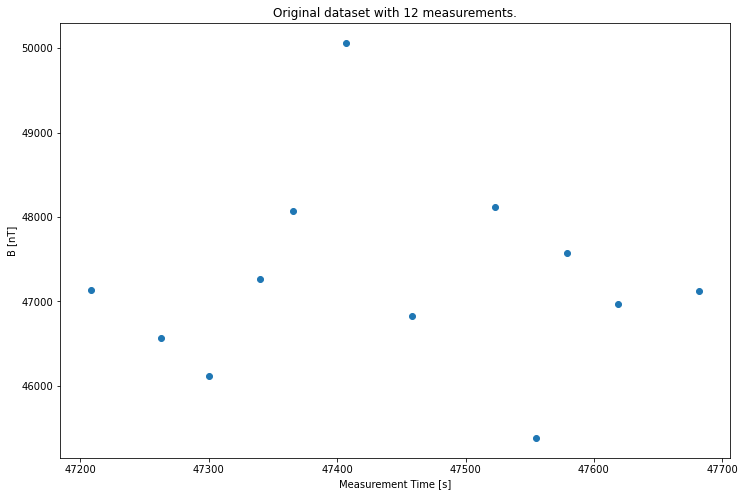

In [17]:
# Plotting all datapoints in order of appearance in the dataset

fig, ax = plt.subplots(figsize=(12, 8))
nData = len(data['field'])
ax.scatter(data['times'], data['field'])
ax.set(xlabel='Measurement Time [s]', ylabel='B [nT]', title=f'Original dataset with {nData} measurements.');

C:\Users\julik\AppData\Local\Temp/ipykernel_12516/4008357567.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:}'.format(int(_)) for _ in ax.get_xticks().tolist()]) # Fixes x-axis tick labels
C:\Users\julik\AppData\Local\Temp/ipykernel_12516/4008357567.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


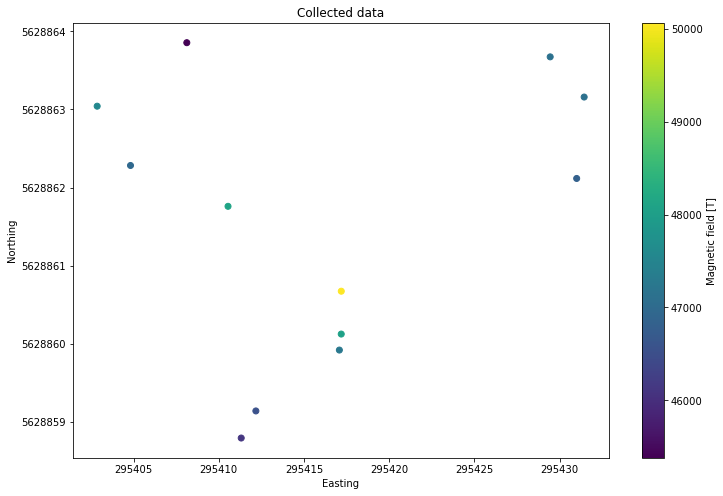

In [18]:
# Plotting the collected data spatially
fig, ax = plt.subplots(figsize=(12, 8))

# Using the temporally corrected anomalies
im = ax.scatter(data['x'], data['y'], c=data['field'])
ax.set(xlabel='Easting', ylabel='Northing', title='Collected data')
ax.set_xticklabels(['{:}'.format(int(_)) for _ in ax.get_xticks().tolist()]) # Fixes x-axis tick labels
ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic field [T]');

## Getting accurate altitude values

The altitudes recorded with your phones' GPS are likely imprecise. We can get accurate altitude values from a DEM of the survey area:

In [19]:
# # Loading the DEM
# # Enter the DEM location and name here (location must be specified relative to this notebook's folder)
# dem_location = 'Drwiss_combined.txt'
# dem = pd.read_csv(dem_location, sep=' ', names=['easting', 'northing', 'altitude'])

In [20]:
# z_dem = []

# for _x, _y in zip(data['x'], data['y']):
#     _x = round(_x, 0)
#     _y = round(_y, 0)
#     mask = np.logical_and(dem['easting'] == _x, dem['northing'] == _y)
#     p = dem.loc[mask]
#     z_dem.append(p['altitude'].values[0].copy())
    
# data['z_dem'] = z_dem

## Handling Outliers

We can now search the dataset for any outliers. There are many ways of defining and identifying outliers, here we will define a threshold value above or below which we want to discard any values. The median of the data will be our point of reference, and any field value lying above or below a predefined range around the median will be discarded.

In [21]:
# Here we set the unilateral range around the median, which defines the window of values we want to keep
rangespan = 1500
median_data = data['field'].median()

# Creating a vector with the absolute differences between each field value and the median
diff_median = np.abs(data['field'] - median_data)

# Storing all datapoints that do not meet the outlier criterion
data_outlier = data.loc[diff_median < rangespan]

# This new dataframe is now void of outliers

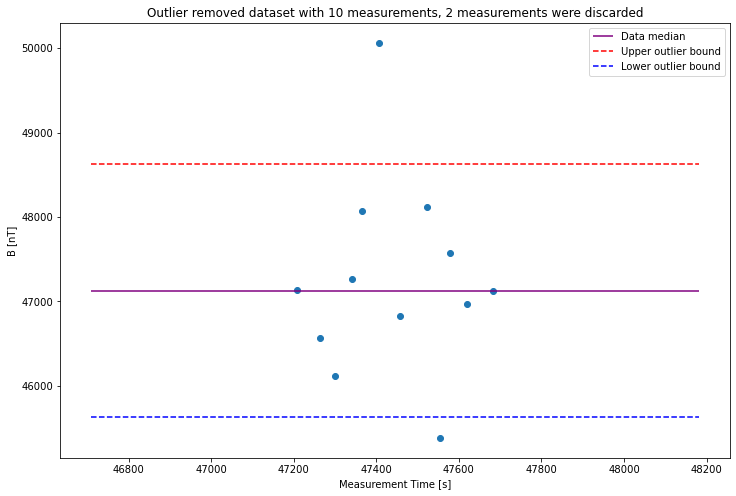

In [22]:
# Now we can plot the dataset with outliers removed
fig, ax = plt.subplots(figsize=(12, 8))

nDataOutlier = len(data_outlier['field'])
ax.scatter(data['times'], data['field'])
ax.hlines(median_data, data['times'].min()-500, data['times'].max()+500, color='purple', label='Data median')
ax.hlines(median_data+rangespan, data['times'].min()-500, data['times'].max()+500,
          linestyles='dashed', color='red', label='Upper outlier bound')
ax.hlines(median_data-rangespan, data['times'].min()-500, data['times'].max()+500,
          linestyles='dashed', color='blue', label='Lower outlier bound')
ax.set(xlabel='Measurement Time [s]', ylabel='B [nT]',
       title=f'Outlier removed dataset with {nDataOutlier} measurements, {nData-nDataOutlier} measurements were discarded');
ax.legend()
#plt.xticks(ticks=range(0, len(times_outlier), 200), labels=times_outlier[::200], rotation=45);

## Data Correction

To obtain magnetic anomalies, we need to extract the anomal part of the data. This can be done by subtracting a calculated (or measured) magnetic field value from the data. Another method is to also correct for the temporal drift which naturally occurs, for which measurements at a base station are needed. In our case, we can also use the smartphone measurements taken at the reference location as base station data. Using these data will also eliminate any measurement deviations that occur between smartphones.

Note that only one appropriate method must be chosen.

## Getting Base Station Data

If we want to use smartphone measurements as base station values, we need to get the values that were taken at the reference point. Since GPS measurements are not entirely precise, we define a tolerance range around which we will accept measurements as base station values. Of course we also have to specify the reference points' coordinates.

C:\Users\julik\AppData\Local\Temp/ipykernel_12516/4088457051.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


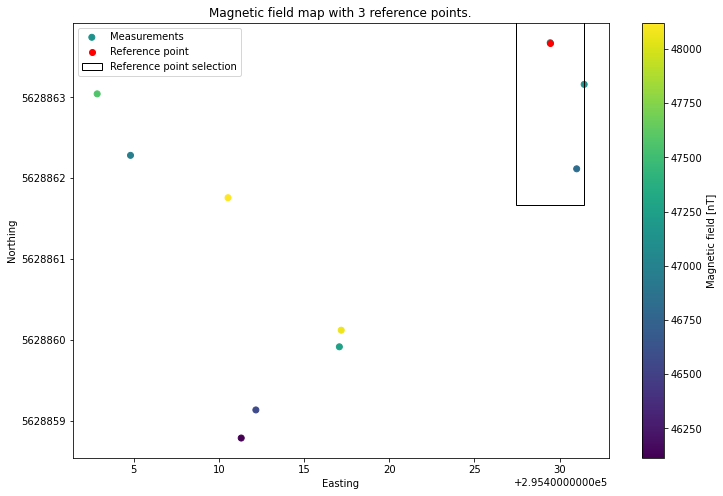

In [24]:
# Defining the reference location and tolerance
# Using first measurement locaion as default
refPointX = data_outlier['x'][0]
refPointY = data_outlier['y'][0]

# Defining the tolerance
tolX = 2
tolY = 2

refMinX, refMaxX = (refPointX-tolX, refPointX+tolX)
refMinY, refMaxY = (refPointY-tolY, refPointY+tolY)

maskX = np.logical_and(data_outlier['x'] < refMaxX, data_outlier['x'] > refMinX)
maskY = np.logical_and(data_outlier['y'] < refMaxY, data_outlier['y'] > refMinY)
maskAll = np.logical_and(maskX, maskY)

data_base = data_outlier.loc[maskAll]
nDataBase = len(data_base['x'])

# Plotting reference measurements
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.scatter(data_outlier['x'], data_outlier['y'], c=data_outlier['field'], clip_on=True, label='Measurements')
ax.set(xlabel='Easting', ylabel='Northing', title=f'Magnetic field map with {nDataBase} reference points.')
refArea = mpl.patches.Rectangle((refMinX, refMinY), width=refMaxX-refMinX, height=refMaxY-refMinY,
                               fill=False, label='Reference point selection')
ax.set_yticklabels(['{:}'.format(int(_)) for _ in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
ax.add_artist(refArea)
im_ref = ax.scatter(refPointX, refPointY, c='r', zorder=3, label='Reference point')
plt.colorbar(im, ax=ax, label='Magnetic field [nT]')
ax.legend(handles=[im, im_ref, refArea]);

If the reference area includes less than 2 points, increase the tolerance. Once the base station values are obtained, they can be used in the time drift correction. Set the variable below to 'temporal' in order to use this type of corrrection. For a theoretical reference correction you can also use enter 'reference'.

## Altitude correction 



There is an altitude dependency of the magnetic field. This correction is undertaken before any other calculations are done, and will be done on the basis of a digital elevation model (DEM) of the area.

In [25]:
# # Defining reference height for altitude correction
# # Using first measurement location as reference
# RefHeight = data_base['z_dem'][0]
# dH = data_outlier['z_dem'] - RefHeight
# R = RefHeight + 6371000 # (earth radius in m)
# field_altitude = data_outlier['field']*(1+(dH/R))**(-3)
# data_outlier['field_alt'] = field_altitude


In [26]:
# fig, ax = plt.subplots(figsize=(12, 8))

# ax.plot(data_outlier['times'], data_outlier['field'], '--', label='Raw data')
# ax.plot(data_outlier['times'], data_outlier['field_alt'], label='Altitude corrected data')
# ax.set(xlabel='Measurement time [s]', ylabel='Magnetic field B [nT]')
# ax.legend()


In [27]:
data_outlier


,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y,times
0,0.0,50.775403,6.098364,172.374120,20.742365,-0.249843,-42.323126,47134.77842,0.284164,65.455,1.656242e+09,51.0,0.0,295429.446103,5.628864e+06,47208.0
1,1.0,50.775356,6.098122,168.160320,18.264511,3.784182,-42.655628,46563.46247,0.356672,119.696,1.656242e+09,49.0,0.0,295412.176139,5.628859e+06,47263.0
2,2.0,50.775352,6.098110,167.967401,14.411419,1.401474,-43.778314,46114.10837,0.292772,156.980,1.656242e+09,51.0,0.0,295411.316247,5.628859e+06,47300.0
3,3.0,50.775364,6.098191,170.328191,19.847165,-0.273140,-42.888051,47260.79383,0.259998,197.081,1.656242e+09,52.0,0.0,295417.075720,5.628860e+06,47340.0
4,4.0,50.775366,6.098193,170.306475,19.722002,0.265950,-43.832667,48067.56652,0.310212,223.549,1.656242e+09,51.0,0.0,295417.185221,5.628860e+06,47366.0
6,6.0,50.775389,6.098387,163.011261,20.083456,0.825263,-42.289506,46824.94039,0.260698,315.470,1.656242e+09,52.0,0.0,295430.999959,5.628862e+06,47458.0
7,7.0,50.775379,6.098098,163.636165,24.928846,1.151593,-41.141015,48120.28332,0.293523,380.554,1.656242e+09,58.0,0.0,295410.542252,5.628862e+06,47523.0
9,9.0,50.775387,6.097988,164.026102,19.591137,-3.789552,-43.178198,47569.79993,0.276914,436.227,1.656242e+09,38.0,0.0,295402.864198,5.628863e+06,47579.0
10,10.0,50.775381,6.098016,162.658198,17.477508,-0.025218,-43.597182,46972.60784,0.340519,475.828,1.656242e+09,55.0,0.0,295404.819890,5.628862e+06,47619.0
11,11.0,50.775399,6.098393,169.255606,20.138953,-0.521282,-42.593270,47118.72660,0.315777,539.257,1.656242e+09,58.0,0.0,295431.439359,5.628863e+06,47682.0


## Determining the anomalies

In [28]:
# Select here how you want to calculate anomalies: 'reference' or 'temporal'
anomaly_method = 'temporal'

### Time drift correction

The earth's magnetic field intensity changes throughout the day. If there is data available from a base station, the temporal drift can be measured and subtracted from the measured data. The base station data then also directly serves as a total field reference value, which means that the resulting values represent the magnetic anomaly relative to the base station location.
The anomaly can also be calculated by using a local theoretical reference value, which is demonstrated in the next section.

C:\Users\julik\AppData\Local\Temp/ipykernel_12516/3304249111.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier['anomaly'] = field_anomaly


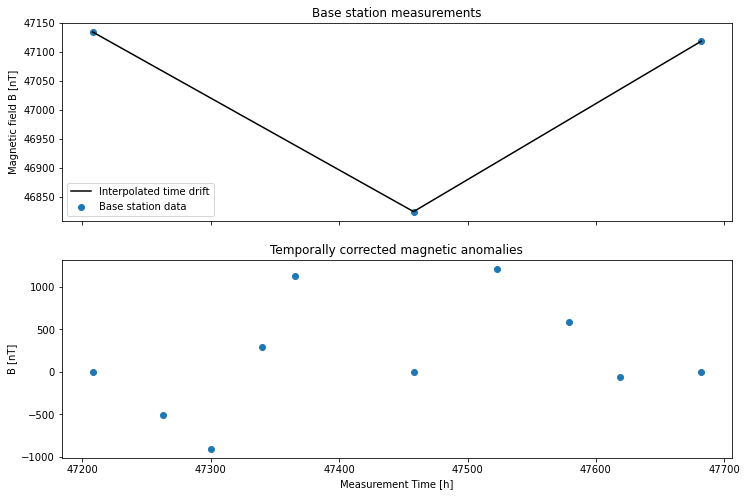

In [29]:
if anomaly_method == 'temporal':
    # In order to get basestation values for the exact times at which our actual measurements were taken,
    # we resample the basestation data. This is done via linear interpolation.

    baseline_interpolator = interpolate.interp1d(data_base['times'], data_base['field'], kind='linear',
                                                 fill_value='extrapolate')
    baseline_field = baseline_interpolator(data_outlier['times'])

    field_anomaly = data_outlier['field'] - baseline_field
    
    # Adding anomalies to dataframe
    data_outlier['anomaly'] = field_anomaly
    
    # Plotting the results

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    
    ax1.scatter(data_outlier['times'], data_outlier['anomaly'])
    ax1.set(xlabel='Measurement Time [h]', ylabel='B [nT]', title='Temporally corrected magnetic anomalies')
    
    ax0.scatter(data_base['times'], data_base['field'], label='Base station data')
    ax0.plot(data_outlier['times'], baseline_field, 'k', label='Interpolated time drift')
    ax0.set(title='Base station measurements', ylabel='Magnetic field B [nT]')
    ax0.legend();

### Substracting Reference Fiel
If there is no base station data available that can act as a local reference value, a theoretical backround value can be determined. Models for the earth's theoretical magnetic field are available, such as the [World Magnetic Model](http://geomag.bgs.ac.uk/data_service/models_compass/wmm_calc.html), which calculate the theoretical field value B for a given location. This can then be used to calculate deviations between our measurements and the 'ideal' value, returning the desired anomaly without accounting for any temporal trends.

In [30]:
if anomaly_method == 'reference':
    # Here we define the background value for the correction, taken from literature or a suitable model
    reference = 49000 # nT

    field_anomaly = data_outlier['field'] - reference
    data_outlier['anomaly'] = field_anomaly
    # Plotting the results

    fig, ax = plt.subplots(figsize=(12,8))

    ax.scatter(data_outlier['times'], data_outlier['anomaly'])
    ax.set(xlabel='Measurement Time [s]', ylabel='B [nT]', title='Theoretical magnetic anomalies')

## Plotting all data

We can now visualize all collected data. Starting with a scatterplot:

C:\Users\julik\AppData\Local\Temp/ipykernel_12516/3744705607.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
C:\Users\julik\AppData\Local\Temp/ipykernel_12516/3744705607.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:}'.format(int(x)) for x in ax2.get_yticks().tolist()]) # Fixes y-axis tick labels


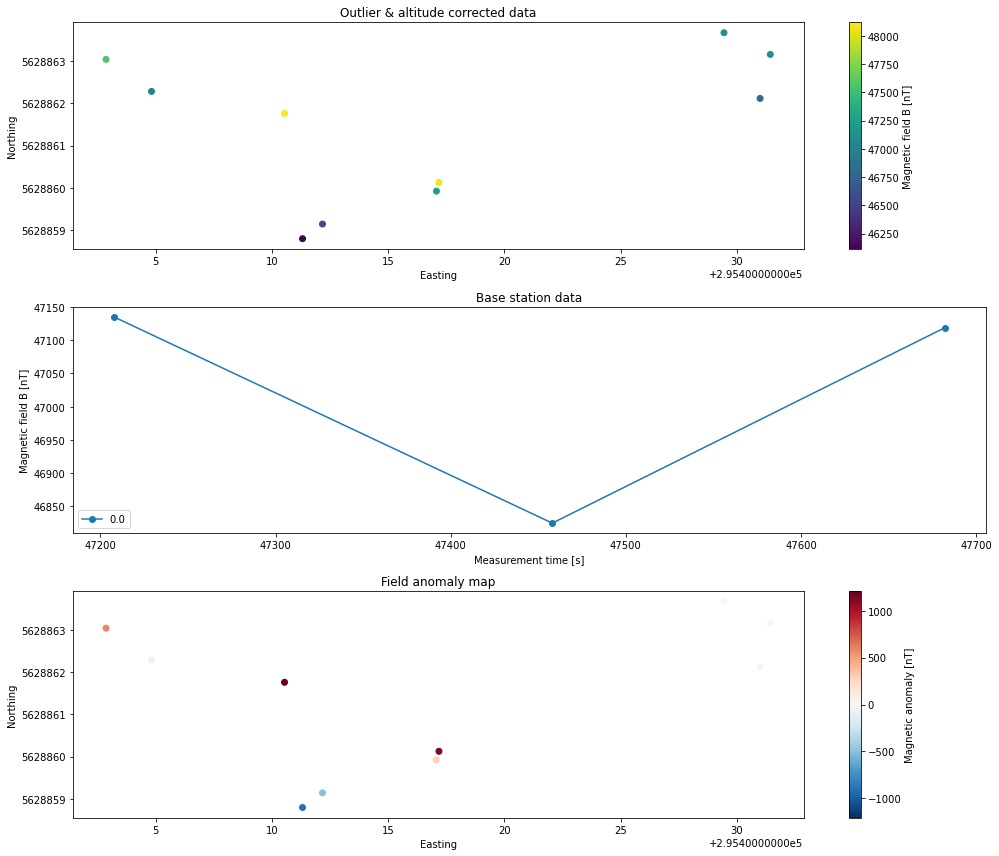

In [31]:
# Basic Anomaly map
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(14, 12))

vmin = -np.max(np.abs(data_outlier['anomaly']))
vmax = np.max(np.abs(data_outlier['anomaly']))

# Using the temporally corrected anomalies
im0 = ax0.scatter(data_outlier['x'], data_outlier['y'], c=data_outlier['field'])
namegroups = data_base.groupby('student_id')
for name, group in namegroups:
    ax1.plot(group['times'], group['field'], '-o', label=name)
ax1.legend()
im2 = ax2.scatter(data_outlier['x'], data_outlier['y'], c=data_outlier['anomaly'],
                  vmin=vmin, vmax=vmax, cmap="RdBu_r")

ax0.set(xlabel='Easting', ylabel='Northing', title='Outlier & altitude corrected data')
ax1.set(xlabel='Measurement time [s]', ylabel='Magnetic field B [nT]', title='Base station data')
ax2.set(xlabel='Easting', ylabel='Northing', title='Field anomaly map')
plt.colorbar(im0, ax=ax0, label='Magnetic field B [nT]');
#plt.colorbar(im1, ax=ax1, label='Magnetic field B [nT]');
plt.colorbar(im2, ax=ax2, label='Magnetic anomaly [nT]');

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
ax2.set_yticklabels(['{:}'.format(int(x)) for x in ax2.get_yticks().tolist()]) # Fixes y-axis tick labels

plt.tight_layout()

## Saving the results

As a last step, we save our results. There are a multitude of ways and fileformats to achieve this. Since we want to store numerical data, [Numpy's save function](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) is a fast and effective method to achieve this. We save the calculated anomalies as well as all data processing steps in between.

In [32]:
# Save the data. Give your datafile a name so it can be distinguished from the others.
yourName = 'Random'
fileName = 'results_magnetic_' + yourName + '.csv'
baseFileName = 'results_magneticBASE_' + yourName + '.csv'

#Enter path where data should be exported too
folder = Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Processed')
data_outlier['name'] = [yourName]*len(data_outlier)

data_base['name'] = [yourName]*len(data_base)
data_outlier.to_csv(folder / fileName)
data_base.to_csv(folder/ baseFileName)

C:\Users\julik\AppData\Local\Temp/ipykernel_12516/2564225288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier['name'] = [yourName]*len(data_outlier)
C:\Users\julik\AppData\Local\Temp/ipykernel_12516/2564225288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_base['name'] = [yourName]*len(data_base)


In [ ]:
A